<a href="https://colab.research.google.com/github/erikycd/Heart_segmentation/blob/main/UNET_pretrained_multiclass-Git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2 as cv

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import backend as K
import keras
print(keras.__version__)

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import layers, models, losses
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras import backend as K

print(tensorflow.__version__)

2.4.3
2.4.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Set some parameters

Path_images = '/content/drive/My Drive/Images/MICCAI MRI/MICCAI MRI/Imagenes/'
Path_mask_1 = '/content/drive/My Drive/Images/MICCAI MRI/MICCAI MRI/VI/'
Path_mask_2 = '/content/drive/My Drive/Images/MICCAI MRI/MICCAI MRI/VD/'

# Path_images = '/content/drive/MyDrive/Images/UNET_segmentation/Images/'
# Path_mask_1 = '/content/drive/MyDrive/Images/UNET_segmentation/Macro/'
# Path_mask_2 = '/content/drive/MyDrive/Images/UNET_segmentation/Micro/'

ids_images = sorted(os.listdir(Path_images))# next(os.walk(Path_Images))[2] # list of names all images in the given path
ids_mask_1 = sorted(os.listdir(Path_mask_1))# next(os.walk(Path_mask_1))[2] # list of mask 1 names
ids_mask_2 = sorted(os.listdir(Path_mask_2))# next(os.walk(Path_mask_2))[2] # list of mask 2 names

print("Total of images :", len(ids_images))
print("Total of masks 1:", len(ids_mask_1))
print("Total of masks 2:", len(ids_mask_2))

Sample_image = cv.imread(Path_images + ids_images[0])
Sample_mask_1 = cv.imread(Path_mask_1 + ids_mask_1[0])
Sample_mask_2 = cv.imread(Path_mask_2 + ids_mask_2[0])

print('Sample image:',Sample_image.shape, Sample_image.min(), Sample_image.max(), 
      Sample_image.dtype)
print('Sample mask 1:',Sample_mask_1.shape, Sample_mask_1.min(), Sample_mask_1.max(),
      Sample_mask_1.dtype)
print('Sample mask 2:',Sample_mask_2.shape, Sample_mask_2.min(), Sample_mask_2.max(),
      Sample_mask_2.dtype)
print('Files images:',ids_images)
print('Files mask 1:',ids_mask_1)
print('Files mask 2:',ids_mask_2)


Total of images : 122
Total of masks 1: 122
Total of masks 2: 122
Sample image: (256, 256, 3) 0 255 uint8
Sample mask 1: (256, 256, 3) 0 255 uint8
Sample mask 2: (256, 256, 3) 0 255 uint8
Files images: ['(1).tiff', '(10).tiff', '(100).tiff', '(101).tiff', '(102).tiff', '(103).tiff', '(104).tiff', '(105).tiff', '(106).tiff', '(107).tiff', '(108).tiff', '(109).tiff', '(11).tiff', '(110).tiff', '(111).tiff', '(112).tiff', '(113).tiff', '(114).tiff', '(115).tiff', '(116).tiff', '(117).tiff', '(118).tiff', '(119).tiff', '(12).tiff', '(120).tiff', '(121).tiff', '(122).tiff', '(13).tiff', '(14).tiff', '(15).tiff', '(16).tiff', '(17).tiff', '(18).tiff', '(19).tiff', '(2).tiff', '(20).tiff', '(21).tiff', '(22).tiff', '(23).tiff', '(24).tiff', '(25).tiff', '(26).tiff', '(27).tiff', '(28).tiff', '(29).tiff', '(3).tiff', '(30).tiff', '(31).tiff', '(32).tiff', '(33).tiff', '(34).tiff', '(35).tiff', '(36).tiff', '(37).tiff', '(38).tiff', '(39).tiff', '(4).tiff', '(40).tiff', '(41).tiff', '(42).tiff'

In [4]:
# Load images and masks into arrays

im_width = Sample_image.shape[0]
im_height = Sample_image.shape[1]

X = np.zeros((len(ids_images), im_height, im_width, 3), dtype=np.float32)
y = np.zeros((len(ids_images), im_height, im_width, 1), dtype=np.float32)
z = np.zeros((len(ids_images), im_height, im_width, 1), dtype=np.float32)
# tqdm is used to display the progress bar
for n, id in tqdm_notebook(enumerate(zip(ids_images,ids_mask_1,ids_mask_2)),
                           total=len(ids_images) ):

    # Load image and intensity transformation [0,1]
    #img = load_img(Path_images + id[0], grayscale = True)
    #x_img = img_to_array(img)
    x_img = cv.imread(Path_images + id[0], cv.IMREAD_GRAYSCALE)
    x_img = img_to_array(x_img)
    x_img = resize(x_img, (im_width, im_height), mode = 'constant', preserve_range = True)
    #x_img = x_img/255.0
    x_img = (x_img - x_img.min())/(x_img.max() - x_img.min())
    x_img = np.repeat(x_img[:, :, :], 3, axis = 2)

    # Load masks 1
    #mask_1 = img_to_array(load_img(Path_mask_1 + id[1], grayscale = True))
    mask_1 = cv.imread(Path_mask_1 + id[1], cv.IMREAD_GRAYSCALE)
    mask_1 = img_to_array(mask_1)
    mask_1 = resize(mask_1, (im_width, im_height), mode = 'constant', preserve_range = True)
    #mask_1 = mask_1/255.0
    mask_1 = (mask_1/mask_1.max())
    mask_1 = 1.*( mask_1 > 0.5 ).astype(np.uint8)

    # Load masks 2
    #mask_2 = img_to_array(load_img(Path_mask_2 + id[2], grayscale = True))
    mask_2 = cv.imread(Path_mask_2 + id[2], cv.IMREAD_GRAYSCALE)
    mask_2 = img_to_array(mask_2)
    mask_2 = resize(mask_2, (im_width, im_height), mode = 'constant', preserve_range = True)
    mask_2 = mask_2/mask_2.max()
    mask_2 = 2.*( mask_2 > 0.5 ).astype(np.uint8)
    #mask_2 = (mask_2 > 0.1).astype(np.uint8)

    # Save images
    X[n] = x_img
    Sum = mask_1 + mask_2
    Sum[Sum > 2] = 0
    y[n] = Sum

print('Tensor images:',X.shape,X.min(),X.max())
print('Tensor masks:',y.shape,y.min(),y.max())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



Tensor images: (122, 256, 256, 3) 0.0 1.0
Tensor masks: (122, 256, 256, 1) 0.0 2.0


In [5]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.2, random_state=0)

print('Tensor X_train:',X_train.shape,X_train.min(),X_train.max())
print('Tensor y_train:',y_train.shape,y_train.min(),y_train.max())

print('Tensor X_valid:',X_valid.shape,X_valid.min(),X_valid.max())
print('Tensor y_valid:',y_valid.shape,y_valid.min(),y_valid.max())

print('Tensor X_test:',X_test.shape,X_test.min(),X_test.max())
print('Tensor y_test:',y_test.shape,y_test.min(),y_test.max())

Tensor X_train: (97, 256, 256, 3) 0.0 1.0
Tensor y_train: (97, 256, 256, 1) 0.0 2.0
Tensor X_valid: (20, 256, 256, 3) 0.0 1.0
Tensor y_valid: (20, 256, 256, 1) 0.0 2.0
Tensor X_test: (5, 256, 256, 3) 0.0 1.0
Tensor y_test: (5, 256, 256, 1) 0.0 2.0


Imagen 0:  (256, 256) float32 0.0 1.0
Both masks:  (256, 256) float32 0.0 2.0
Mask class 2:  (256, 256) bool False True
Mask class 2:  (256, 256) bool False True


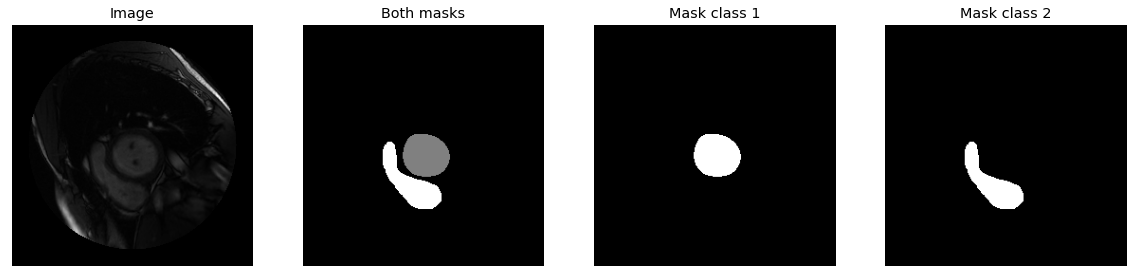

In [6]:
# Visualization

plt.figure(figsize=(20,20))

label = 1
plt.subplot(1,4,1)
a = X_train[label,:,:,0]
print('Imagen 0: ',a.shape, a.dtype, a.min(), a.max())
plt.imshow(a, cmap='gray')
plt.title("Image")
plt.xticks([])
plt.yticks([])

plt.subplot(1,4,2)
b = y_train[label,:,:,0]
print('Both masks: ',b.shape, b.dtype, b.min(), b.max())
plt.imshow(b, cmap='gray')
plt.title("Both masks")
plt.xticks([])
plt.yticks([])

plt.subplot(1,4,3)
c = y_train[label,:,:,0]==1
print('Mask class 2: ',c.shape, c.dtype, c.min(), c.max())
plt.imshow(c, cmap='gray')
plt.title("Mask class 1")
plt.xticks([])
plt.yticks([])

plt.subplot(1,4,4)
d = y_train[label,:,:,0]==2
print('Mask class 2: ',d.shape, d.dtype, d.min(), d.max())
plt.imshow(d, cmap='gray')
plt.title("Mask class 2")
plt.xticks([])
plt.yticks([])

plt.show()

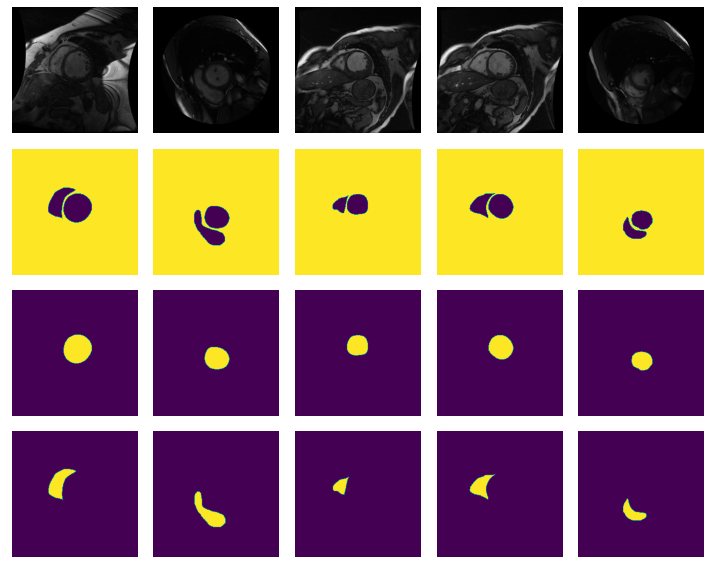

In [24]:
def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=5):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap='gray')
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

y_train_categorical = to_categorical(y_train)
visualize(X_train[:], y_train_categorical[:])

In [8]:
#@title Active_Contour_Loss
@tf.function
def Active_Contour_Loss(y_true, y_pred): 

  columns = y_pred.shape[1]
  rows = y_pred.shape[2]

  """
  length term
  """

  x = y_pred[:,1:,:,:] - y_pred[:,:-1,:,:] # (batch,columns-1,rows,channels)
  y = y_pred[:,:,1:,:] - y_pred[:,:,:-1,:] # (batch,columns,rows-1,channels)

  delta_x = K.square(x[:,1:,:-2,:]) # (batch,columns-2,rows-2,channels)
  delta_y = K.square(y[:,:-2,1:,:]) # (batch,columns-2,rows-2,channels)

  epsilon = 0.00000001
  delta_u = K.sqrt(K.abs(delta_x + delta_y) + epsilon ) # (batch,columns-2,rows-2,channels)

  length = K.sum(delta_u, axis=[1,2]) # (batch,1)

  """
  region term
  """

  C1 = tf.ones_like(y_pred) # ones(batch,columns,rows,channels)
  C2 = tf.zeros_like(y_pred) # zeros(batch,columns,rows,channels)

  #C1 = K.sum(y_true*y_pred , axis=[1,2]) / K.sum(y_pred,[1,2])
  #C2 = K.sum(y_true*(1-y_pred) , axis=[1,2]) / K.sum(1-y_pred,[1,2])

  sum_in = K.sum( (K.square(y_true - C1) * y_pred), axis =[1,2] ) # (batch,1)
  sum_out = K.sum( (K.square(y_true - C2) * (1 - y_pred)), axis=[1,2] ) #(batch,1)

  region_in = K.abs(sum_in) #(batch,1)
  region_out = K.abs(sum_out) #(batch,1)

  """
  final loss
  """

  mu_1 = 0.1
  lambda_1 = 5
  lambda_2 = 5

  Loss_AC = mu_1*length + lambda_1*region_in + lambda_2*region_out

  tf.print(Loss_AC)

  return Loss_AC

In [9]:
#@title ACL_1
@tf.function
def ACL_1(y_true, y_pred): 

  """
  length term
  """

  x = y_pred[:,1:,:,:] - y_pred[:,:-1,:,:] 
  y = y_pred[:,:,1:,:] - y_pred[:,:,:-1,:]
  delta_x = x[:,1:,:-2,:]**2
  delta_y = y[:,:-2,1:,:]**2
  delta_u = K.abs(delta_x + delta_y) 

  epsilon_1 = 0.00000001
  length = K.sum(K.sqrt(delta_u + epsilon_1)) 

  """
  region term
  """
  rows = y_pred.shape[1]
  columns = y_pred.shape[2]
  C_1 = np.ones((rows, columns))
  C_2 = np.zeros((rows, columns))

  region_in = K.abs(K.mean( y_pred[:,:,:,0] * ((1 - y_true[:,:,:,0])**2) )) 
  region_out = K.abs(K.mean( (1 - y_pred[:,:,:,0]) * ((- y_true[:,:,:,0])**2) )) 

  mu_1 = 0.1
  lambda_1 = 1
  lambda_2 = 1

  Loss_AC = mu_1*length + lambda_1*region_in + lambda_2*region_out

  tf.print(Loss_AC)

  return Loss_AC

In [10]:
#@title ACL_0
def ACL_0(y_true, y_pred): 
    
    #y_true = K.cast(y_true, dtype = 'float64') 
    #y_pred = K.cast(y_pred, dtype = 'float64') 
    
    """
    lenth term
    """
       
    #Reordered indexes, because data format is different.
    x = y_pred[:,1:,:,:] - y_pred[:,:-1,:,:] #y_true shape is: (8, 256, 256, 1)  
    y = y_pred[:,:,1:,:] - y_pred[:,:,:-1,:] #y_pred shape is: (8, 256, 256, 1)
        
    delta_x = x[:,1:,:-2,:]**2
    delta_y = y[:,:-2,1:,:]**2    
    
    delta_u = K.abs(delta_x + delta_y) 

    epsilon = 0.00000001 # where is a parameter to avoid square root is zero in practice.
    w = 1
    length = w * K.sum(K.sqrt(delta_u + epsilon)) # equ.(11) in the paper

    """
    region term
    """

    C_1 = np.ones((256, 256))
    C_2 = np.zeros((256, 256))    
    
    #Reordered indexes, because data format is different.
    region_in = K.abs(K.sum( y_pred[:,:,:,0] * ((y_true[:,:,:,0] - C_1)**2) ) ) # equ.(12) in the paper
    region_out = K.abs(K.sum( (1-y_pred[:,:,:,0]) * ((y_true[:,:,:,0] - C_2)**2) )) # equ.(12) in the paper

    lambdaP = 1 # lambda parameter could be various.
	
    loss =  length + lambdaP * (region_in + region_out) # equ. (8) in the paper
    
    return loss


In [11]:
#@title Total_variation_loss
def Total_variation_loss(y_true,y_pred):

  columns = y_pred.shape[1]
  rows = y_pred.shape[2]

  # Regularization term:

  x = y_pred[:,1:,:,:] - y_pred[:,:-1,:,:] # (batch,columns-1,rows,channels)
  y = y_pred[:,:,1:,:] - y_pred[:,:,:-1,:] # (batch,columns,rows-1,channels)

  delta_x = K.square(x[:,1:,:-2,:]) # (batch,columns-2,rows-2,channels)
  delta_y = K.square(y[:,:-2,1:,:]) # (batch,columns-2,rows-2,channels)

  epsilon = 0.00000001
  delta_u = K.sqrt(K.abs(delta_x + delta_y) + epsilon )

  regularization = K.sum(delta_u, axis=[1,2])

  # Data fidelity term:

  mu_1 = 0.1
  lambda_1 = 1#/(rows*columns)

  data = K.square(y_pred - y_true)
  data_fidelity = K.sum(data, axis=[1,2])

  total_variation = mu_1*regularization + lambda_1*data_fidelity
  #total_variation = lambda_1*data_fidelity
  
  return total_variation


In [12]:
def conv_block(input_tensor, num_filters):
  encoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same', depth_multiplier=1)(input_tensor)
  encoder = layers.BatchNormalization(axis=-1)(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.SpatialDropout2D(0.2)(encoder)
  encoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same', depth_multiplier=1)(encoder)
  encoder = layers.BatchNormalization(axis=-1)(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.SpatialDropout2D(0.2)(encoder)
  return encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor) #, kernel_initializer = keras.initializers.he_uniform())(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization(axis=-1)(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same', depth_multiplier=1)(decoder)
  #decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization(axis=-1)(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.SpatialDropout2D(0.2)(decoder)
  decoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same', depth_multiplier=1)(decoder)
  #decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization(axis=-1)(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.SpatialDropout2D(0.2)(decoder)
  return decoder

In [13]:
Resnet = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights='imagenet',  
                                                    input_shape=(256,256,3), pooling=None)
encoder0 = Resnet.layers[0].output #640 , 64
encoder1 = Resnet.get_layer('conv1_conv').output #320, 64
encoder2 = Resnet.get_layer('conv2_block3_1_relu').output #160, 64
encoder3 = Resnet.get_layer('conv3_block4_1_relu').output #80, 128
encoder4 = Resnet.get_layer('conv4_block6_1_relu').output #40, 256
center = Resnet.layers[-1].output #20, 2048
for i in range( len(Resnet.layers) ):
  Resnet.layers[i].trainable = False


#decoder4 = decoder_block(center, encoder4, 256)
decoder4 = decoder_block(center, encoder4, 256)

#decoder3 = decoder_block(decoder4, encoder3, 128)
decoder3 = decoder_block(decoder4, encoder3, 128)

#decoder2 = decoder_block(decoder3, encoder2, 64)
decoder2 = decoder_block(decoder3, encoder2, 128)

#decoder1 = decoder_block(decoder2, encoder1, 64)
decoder1 = decoder_block(decoder2, encoder1, 64)

#decoder0 = decoder_block(decoder1, encoder0, 64)
decoder0 = decoder_block(decoder1, encoder0, 32)

outputs1 = layers.Conv2D(3, (1, 1), activation = 'softmax')(decoder0)

In [14]:
model = models.Model(inputs=[Resnet.input], outputs=[outputs1])

#model.compile(optimizer='Adam', loss= 'binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=Adam(lr=0.005), loss=ACL_1, metrics=["accuracy"])
#model.compile(optimizer=Adam(lr=0.005), loss=ACL_1, metrics=["accuracy"])
#model.compile(optimizer=Adam(lr=0.005), loss=Total_variation_loss, metrics=["accuracy"])
#model.compile(optimizer=Adam(lr=0.005), loss=Active_Contour_Loss, metrics=["accuracy"])
model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.005), 
              loss = losses.sparse_categorical_crossentropy, 
              metrics = ['sparse_categorical_accuracy'] )

In [15]:
callbacks = [
    #EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1),
    ModelCheckpoint('model-Unet_multiclass_1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train, y_train, 
                    batch_size = 4, 
                    epochs = 40, 
                    callbacks = callbacks,
                    validation_data = (X_valid, y_valid)
                    )

Epoch 1/40
25/25 [==============================] - 44s 261ms/step - loss: 1.1711 - sparse_categorical_accuracy: 0.4323 - val_loss: 0.7231 - val_sparse_categorical_accuracy: 0.9590

Epoch 00001: val_loss improved from inf to 0.72314, saving model to model-Unet_multiclass_1.h5
Epoch 2/40
25/25 [==============================] - 4s 156ms/step - loss: 0.3090 - sparse_categorical_accuracy: 0.9446 - val_loss: 0.4662 - val_sparse_categorical_accuracy: 0.9590

Epoch 00002: val_loss improved from 0.72314 to 0.46619, saving model to model-Unet_multiclass_1.h5
Epoch 3/40
25/25 [==============================] - 4s 158ms/step - loss: 0.2003 - sparse_categorical_accuracy: 0.9437 - val_loss: 0.3117 - val_sparse_categorical_accuracy: 0.9590

Epoch 00003: val_loss improved from 0.46619 to 0.31169, saving model to model-Unet_multiclass_1.h5
Epoch 4/40
25/25 [==============================] - 4s 159ms/step - loss: 0.1352 - sparse_categorical_accuracy: 0.9525 - val_loss: 0.1878 - val_sparse_categorical_

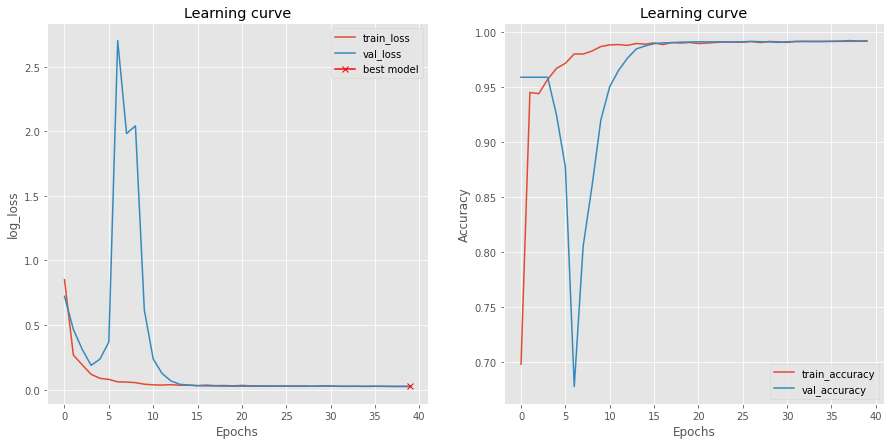

In [16]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.title("Learning curve")
plt.plot(results.history["loss"], label="train_loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.subplot(1,2,2)
plt.title("Learning curve")
plt.plot(results.history['sparse_categorical_accuracy'], label='train_accuracy')
plt.plot(results.history['val_sparse_categorical_accuracy'], label= 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

In [17]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 3s 3s/step - loss: 0.0251 - sparse_categorical_accuracy: 0.9918


[0.025076260790228844, 0.9917991757392883]

In [18]:
predicted_label = model.predict(X_test)
print('Predicted label shape: ',predicted_label.shape, predicted_label.dtype, predicted_label.min(), predicted_label.max())
predicted_mask = to_categorical(np.argmax(predicted_label, -1), dtype='uint8')
print('Predicted mask shape: ',predicted_mask.shape, predicted_mask.dtype, predicted_mask.min(), predicted_mask.max())
print('y_test shape: ',y_test.shape, y_test.dtype, y_test.min(), y_test.max())

Predicted label shape:  (5, 256, 256, 3) float32 2.87601e-07 0.9999968
Predicted mask shape:  (5, 256, 256, 3) uint8 0 1
y_test shape:  (5, 256, 256, 1) float32 0.0 2.0


In [19]:
def dice_coeff(y_true, y_pred):

  Dice_class_1 = np.zeros(y_true.shape[0])
  Dice_class_2 = np.zeros(y_true.shape[0])

  for k in range(y_true.shape[0]):

    img1 = np.asarray(y_true[k,:,:,0]==1).astype(np.bool)
    img2 = np.asarray(y_pred[k,:,:,1]).astype(np.bool)
    if img1.sum() + img2.sum() == 0: return 1
    intersection = np.logical_and(img1, img2)
    Dice_class_1[k] = 2. * intersection.sum() / (img1.sum() + img2.sum())

    img3 = np.asarray(y_true[k,:,:,0]==2).astype(np.bool)
    img4 = np.asarray(y_pred[k,:,:,2]).astype(np.bool)
    if img3.sum() + img4.sum() == 0: return 1
    intersection = np.logical_and(img3, img4)
    Dice_class_2[k] = 2. * intersection.sum() / (img3.sum() + img4.sum())

  return Dice_class_1, Dice_class_2

In [20]:
Dice_class_1 , Dice_class_2 = dice_coeff(y_test,predicted_mask)

print('Shape of true labels:',y_test.shape,y_test.min(),y_test.max())
print('Shape of predicted labels:',predicted_mask.shape,predicted_mask.min(),predicted_mask.max())

print('Dice mean class 1:',Dice_class_1.mean())
print('Dice per image_class_1:',Dice_class_1)

print('Dice mean class 2:',Dice_class_2.mean())
print('Dice per image_class_2:',Dice_class_2)


Shape of true labels: (5, 256, 256, 1) 0.0 2.0
Shape of predicted labels: (5, 256, 256, 3) 0 1
Dice mean class 1: 0.9528145208925775
Dice per image_class_1: [0.96977929 0.95362663 0.97360996 0.89881956 0.96823716]
Dice mean class 2: 0.8761047549105341
Dice per image_class_2: [0.9401285  0.80569271 0.9441469  0.80527541 0.88528025]


Imagen:  (256, 256) float32 0.0 1.0
True mask:  (256, 256) float32 0.0 2.0
Predicted mask:  (256, 256) float64 0.0 2.0


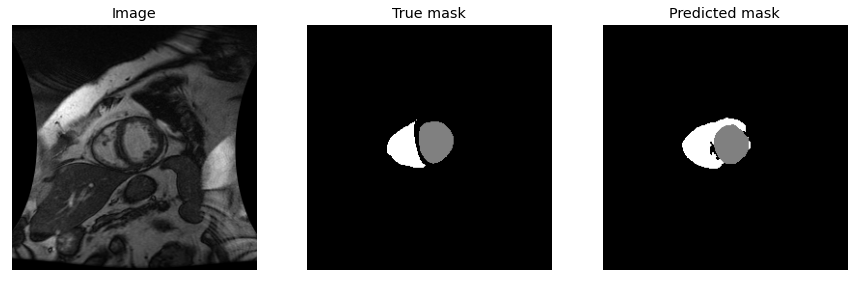

In [21]:
plt.figure(figsize=(15,15))

label = 3
plt.subplot(1,3,1)
a = X_test[label,:,:,0]
print('Imagen: ',a.shape, a.dtype, a.min(), a.max())
plt.imshow(a, cmap='gray')
plt.title("Image")
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,2)
b = y_test[label,:,:,0]
print('True mask: ',b.shape, b.dtype, b.min(), b.max())
plt.imshow(b, cmap='gray')
plt.title("True mask")
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,3)
c = predicted_mask[label,:,:,1] + 2.*(predicted_mask[label,:,:,2])
print('Predicted mask: ',c.shape, c.dtype, c.min(), c.max())
plt.imshow(c, cmap='gray')
plt.title("Predicted mask")
plt.xticks([])
plt.yticks([])

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], <a list of 0 Text major ticklabel objects>)

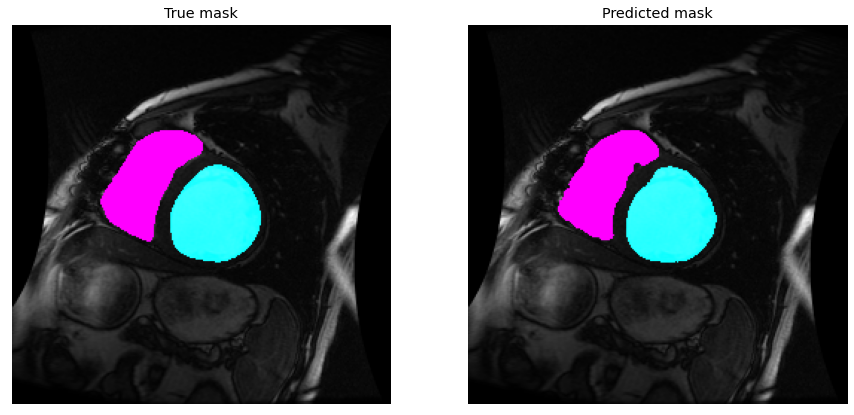

In [22]:
def mask_color_img(img, mask_1, color_1, mask_2, color_2, alpha=0.3):
    '''
    img: cv2 image
    mask: bool or np.where
    color: BGR triplet [_, _, _]. Default: [0, 255, 255] is yellow.
    alpha: float [0, 1]. 

    Ref: http://www.pyimagesearch.com/2016/03/07/transparent-overlays-with-opencv/
    '''
    out = img.copy()
    img_layer = img.copy()
    img_layer[mask_1] = color_1
    out = cv.addWeighted(img_layer, alpha, out, 1 - alpha, 0, out)

    out[mask_2] = color_2
    out2 = cv.addWeighted(out, alpha, out, 1 - alpha, 0, out)

    return out2


label = 2
a = X_test[label,:,:,0]
Image_rgb = np.repeat(a[:, :, np.newaxis], 3, axis=2)

true_class_1 = y_test[label,:,:,0]==1
true_class_2 = y_test[label,:,:,0]==2

True_mask = mask_color_img(Image_rgb,true_class_1,[0,255,255],
                           true_class_2,[100,0,200],alpha = 0.1)


predicted_class_1 = predicted_mask[label,:,:,1]==1
predicted_class_2 = predicted_mask[label,:,:,2]==1

Predicted_mask = mask_color_img(Image_rgb,predicted_class_1,[0,255,255],
                                predicted_class_2,[100,0,200],alpha = 0.1)


plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.imshow(True_mask)
plt.title("True mask")
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(Predicted_mask)
plt.title("Predicted mask")
plt.xticks([])
plt.yticks([])

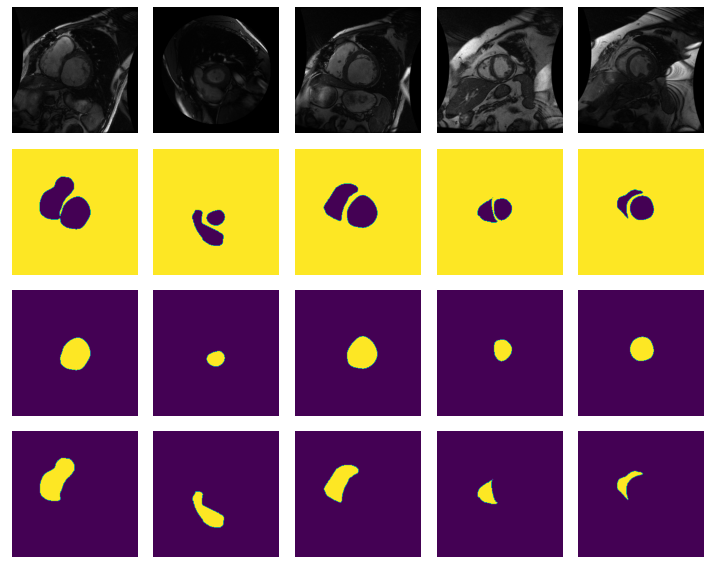

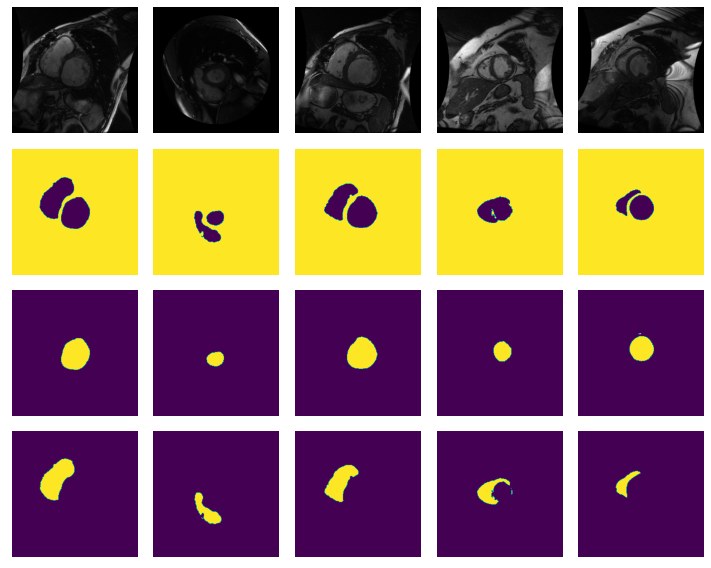

In [25]:
y_test_categorical = to_categorical(y_test)
visualize(X_test, y_test_categorical)

visualize(X_test , predicted_mask)